# Summary of Available Sensorimotor and Interest Models

In this notebook, we summarize the different sensorimotor and interest models available in the Explauto library, and give some explanations or references. We suppose that the reader is familiar with the main components of the Explauto library explained in another notebook ([full tutorial](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/full_tutorial.ipynb)): the environment, the sensorimotor model and the interest model.

Let's begin with defining a simple environment that will be used to test the sensorimotor models.

In [1]:
from explauto.environment.environment import Environment
environment = Environment.from_configuration('simple_arm', 'mid_dimensional')

# Sensorimotor models

In Explauto, a sensorimotor model implements both the iterative learning process from sensorimotor experience, i.e. from the iterative collection of $(m, s)$ pairs by interaction with the environment, and the use of the resulting internal model to perform forward and inverse predictions (or any kind of general prediction between sensorimotor subspaces). 

Learning sensorimotor mappings involves machine learning algorithms, for which Explauto provides a unified interface through the [SensorimotorModel abstract class](http://flowersteam.github.io/explauto/explauto.sensorimotormodel.html#explauto.sensorimotor_model.sensorimotor_model.SensorimotorModel). 

Using the simple arm environment above, it allows to iteratively learn a sensorimotor model which will be able to:
* infer the position of the end-effector from a given motor command, what is called *forward prediction*,
* infer the motor command allowing to reach a particular end-effector position, what is called *inverse prediction*.
* update online from sensorimotor experience

Several sensorimotor models are provided: simple nearest-neighbor look-up, non-parametric models combining classical regressions and optimization algorithms, online local mixtures of Gaussians (beta). Here we will only explain non-parametric models.

Non-parametric models can be decomposed into a dataset, a forward model, and an inverse model. 

The dataset just stores all the experiments (m, s) into a list.

The forward model uses the dataset for the forward prediction computation, and the inverse model uses the forward model, or directly the dataset to perform inverse prediction.

All the non-parametric sensorimotor models have two operating modes: "explore" and "exploit".

In the "explore" mode, when the agent asks for the exact inverse prediction $m$ of a goal $s_g$, $m$ will be perturbated with some gaussian exploration noise in order to allow the agent to explore new motor commands. The sensorimotor models thus have a common parameter: sigma_explo_ratio=0.1 (default), which is the standard deviation of the gaussian noise, scaled depending of the motor domain size: if a motor value is bounded in [-2:2], then a sigma_explo_ratio of 0.1 will induce an exploration noise of (m_max - m_min) * sigma_explo_ratio = 0.4

In the "exploit" mode, no exploration noise is added. This mode is used for instance when evaluating the inverse model for comparison purposes.

## Forward Models:

### NN Forward model

### WNN Forward model

[link](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

### LWLR Forward model

Locally Weigthed Regression (LWR)

References :
1. https://en.wikipedia.org/wiki/Local_regression
2. C. G. Atkeson, A. W. Moore, S. Schaal, "[Locally Weighted Learning for Control](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.468.7121&rep=rep1&type=pdf)", "Springer Netherlands", 75-117, vol 11, issue 1, 1997/02, 10.1023/A:1006511328852    
3. See also a [video](http://www.cosmolearning.com/video-lectures/locally-weighted-regression-probabilistic-interpretation-logistic-regression/) lecture on LWR.

Pseudo Code :


## Inverse Models

### NN Inverse Model

### WNN Inverse Model

### BFGS Inverse model

See [wikipedia](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm) for more details and a pseudo code.

### CMAES Inverse model

[Hansen's website](https://www.lri.fr/~hansen/cmaesintro.html)

[Tutorial](https://www.lri.fr/~hansen/cmatutorial.pdf) on CMA-ES

## Combinations of one forward and one inverse model: sensorimotor model

Combinations of a forward and an inverse model can be instanciated using 'fwd' and 'inv' options.

Possible 'fwd':  'NN', 'WNN', 'LWLR', 'NSNN', 'NSLWLR'

Possible 'inv':  'NN', 'WNN', 'BFGS', 'L-BFGS-B', 'COBYLA', 'CMAES', 'Jacobian'

'NSNN' and 'NSLWLR' are modified versions of 'NN' and 'LWLR' where points are not only weighted by distance but also by the number of points that appeared after that one (gaussian with parameter sigma_t=100), to put less weight on old points and allow the learning of Non-Stationnary environments.

Here are the already provided combinations:

In [16]:
from explauto.sensorimotor_model import sensorimotor_models, available_configurations
sensorimotor_models.keys()

['LWLR-BFGS', 'nearest_neighbor', 'WNN', 'LWLR-CMAES']

For each combination, we can use one of the possible configurations (use available_configurations to find them), or we can define our own configuration. See the following for some exemples.

### 'nearest_neighbor'

In [19]:
available_configurations('nearest_neighbor')

{'default': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.1},
 'exact': {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio': 0.0}}

In [ ]:
sm_model = SensorimotorModel.from_configuration(environment.conf, "nearest_neighbor", "default")

We also can specify the parameters by hand:

In [ ]:
from explauto.sensorimotor_model.non_parametric import NonParametric
params = {'fwd': 'NN', 'inv': 'NN', 'sigma_explo_ratio':0.1}
sm_model = NonParametric(environment.conf, **params)

### 'WNN'

In [ ]:
params = {'fwd': 'WNN', 'inv': 'WNN', 'k':20, 'sigma':0.1}
sm_model = NonParametric(environment.conf, **params)

### 'LWLR-BFGS'

In [7]:
params = {'fwd': 'LWLR', 'k':10, 'inv': 'L-BFGS-B', 'maxfun':50}
sm_model = NonParametric(environment.conf, **params)

### 'LWLR-CMAES'

In [8]:
params = {'fwd': 'LWLR', 'k':10, 'inv': 'CMAES', 'cmaes_sigma':0.05, 'maxfevals':20}
sm_model = NonParametric(environment.conf, **params)

## Simple test

Choose a sensorimotor model and try the following test.

Populating the interactive namespace from numpy and matplotlib
Inferred motor command to reach the position  [0.7, 0.5] :  [ 0.04929337  0.64660133  0.75256724 -0.96294939  0.556032   -0.25560069
  0.03942533]


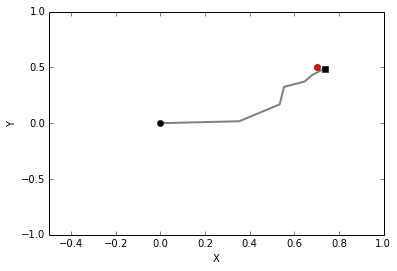

In [9]:
%pylab inline
for m in environment.random_motors(n=1000):
    # compute the sensori effect s of the motor command m through the environment:
    s = environment.compute_sensori_effect(m)
    # update the model according to this experience:
    sm_model.update(m, s)
    
sm_model.mode = "exploit"
s_g = [0.7, 0.5]
m = sm_model.inverse_prediction(s_g)
print 'Inferred motor command to reach the position ', s_g, ': ', m

ax = axes()
environment.plot_arm(ax, m)
ax.plot(*s_g, marker='o', color='red')

# Interest models

See this [notebook](http://nbviewer.ipython.org/github/flowersteam/explauto/blob/master/notebook/introducing_curiosity_learning.ipynb) for a comparison of 'random', 'discretized_progress' and 'tree' interest models.

In [10]:
from explauto.interest_model import interest_models, available_configurations
interest_models.keys()

['discretized_progress', 'tree', 'random', 'gmm_progress_beta']

In [11]:
available_configurations('discretized_progress')

{'default': {'measure': <function explauto.interest_model.competences.competence_dist>,
  'win_size': 10,
  'x_card': 400}}

### 'random'

In [12]:
from explauto.interest_model.random import RandomInterest
im_model = RandomInterest(environment.conf, environment.conf.s_dims)

from explauto import InterestModel
im_model = InterestModel.from_configuration(environment.conf, environment.conf.s_dims, 'random')

### 'discretized_progress'

In [13]:
from explauto.interest_model.discrete_progress import DiscretizedProgress, competence_dist

im_model = DiscretizedProgress(environment.conf, environment.conf.s_dims, **{'x_card': 1000,
                                                                             'win_size': 10,
                                                                             'measure': competence_dist})

### 'tree'

Here is the [article](http://www.sciencedirect.com/science/article/pii/S0921889012000644) presenting the SAGG-RIAC algorithm. We re-implemented the algorithm here in python, with several implementation options.

In [14]:
from explauto.interest_model.tree import InterestTree, competence_exp

im_model = InterestTree(environment.conf, environment.conf.s_dims, **{'max_points_per_region': 100,
                                                                       'max_depth': 20,
                                                                       'split_mode': 'best_interest_diff',
                                                                       'competence_measure': lambda target,reached : competence_exp(target, reached, 0., 10.),
                                                                       'progress_win_size': 50,
                                                                       'progress_measure': 'abs_deriv_smooth',                                                     
                                                                       'sampling_mode': {'mode':'softmax', 
                                                                                         'param':0.2,
                                                                                         'multiscale':False,
                                                                                         'volume':True}})

### 'gmm_progress_beta'

In [15]:
from explauto.interest_model.gmm_progress import GmmInterest, competence_exp

im_model = GmmInterest(environment.conf, environment.conf.s_dims, **{'measure': competence_exp,
                                                                      'n_samples': 40,
                                                                      'n_components': 6})

## Simple test

Choose an interest model and try the following test.